In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [92]:
actions = pd.read_csv("../data/processed_balabit_actions.csv")
actions.head()

traveled_distance_pixel  elapsed_time  direction_of_movement  straightness  \
0                 7.000000         0.125                      0      1.000000   
1                89.008474         0.437                      0      0.999968   
2                 3.000000         0.125                      0      1.000000   
3              1051.510748         3.369                      0      0.310032   
4                42.000000         0.390                      0      1.000000   

   num_points  sum_of_angles  mean_curv   sd_curv  max_curv  min_curv  ...  \
0           4       0.000000   0.000000  0.000000  0.000000  0.000000  ...   
1           5       0.016948  -0.000634  0.001366  0.000287 -0.002825  ...   
2           4       0.000000   0.000000  0.000000  0.000000  0.000000  ...   
3          29      12.039747   0.060570  0.315803  1.570796 -0.397340  ...   
4           5       0.000000   0.000000  0.000000  0.000000  0.000000  ...   

           max_a         min_a     mean_jerk       sd_jerk      max_jerk  \
0    4516.571846    226.346763  4.693410e+04  7.192898e+04  1.383944e+05   
1    4876.733356  -3192.173926  1.028403e+04  4.642847e+04  4.852595e+04   
2    2759.460881    168.336000  5.449656e+04  8.470291e+04  1.619453e+05   
3  453622.366109 -35550.347568  1.636646e+06  8.584419e+06  4.520804e+07   
4    1105.619150   -439.915889 -9.566141e+02  1.093836e+04  8.916283e+03   

       min_jerk  a_beg_time  user16  action_3  action_4  
0  2.407944e+03       0.125       1         0         1  
1 -5.172376e+04       0.110       1         0         0  
2  1.544367e+03       0.125       1         0         1  
3 -3.135723e+06       0.109       1         1         0  
4 -1.644186e+04       0.124       1         0         0  

[5 rows x 41 columns]

In [93]:
actions.columns

Index(['traveled_distance_pixel', 'elapsed_time', 'direction_of_movement',
       'straightness', 'num_points', 'sum_of_angles', 'mean_curv', 'sd_curv',
       'max_curv', 'min_curv', 'mean_omega', 'sd_omega', 'max_omega',
       'min_omega', 'largest_deviation', 'dist_end_to_end_line',
       'num_critical_points', 'mean_vx', 'sd_vx', 'max_vx', 'min_vx',
       'mean_vy', 'sd_vy', 'max_vy', 'min_vy', 'mean_v', 'sd_v', 'max_v',
       'min_v', 'mean_a', 'sd_a', 'max_a', 'min_a', 'mean_jerk', 'sd_jerk',
       'max_jerk', 'min_jerk', 'a_beg_time', 'user16', 'action_3', 'action_4'],
      dtype='object')

In [94]:
# split into features and target variable
X = actions.drop("user16", axis=1)
y = actions["user16"]

norm_X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.3,
                                                    random_state=42)

In [95]:
# normalize data

norm_train = normalize(X_train)
norm_test = normalize(X_test)

#X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.3,
#                                                    random_state=42)

In [96]:
# test inertia for varying number of clusters
clusters = []

for i in range(1, 5):
    km = KMeans(n_clusters=i).fit(norm_train)
    clusters.append(km.inertia_)

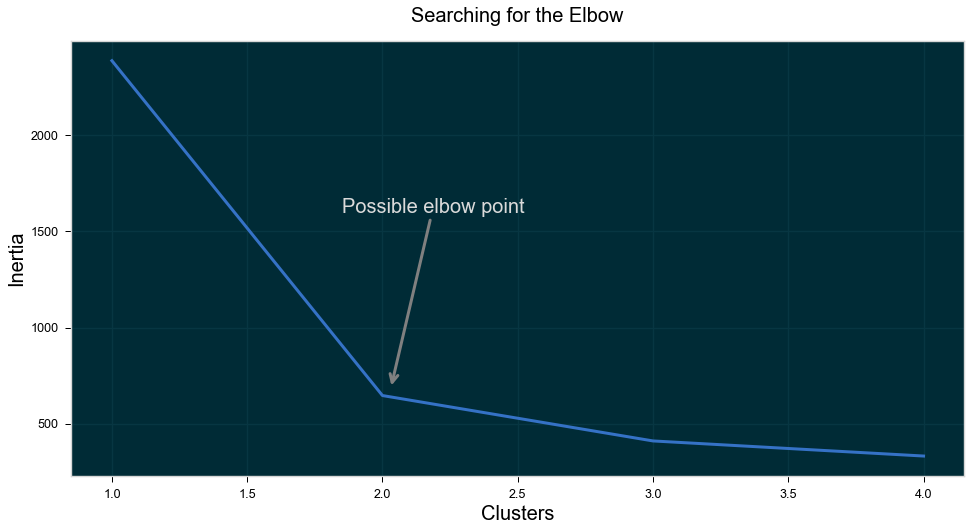

In [97]:
# check the elbow plot to see if a suggested number of clusters comes out
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=list(range(1, 5)), y=clusters, ax=ax, lw=3)
ax.set_title("Searching for the Elbow", color="black", size=20, y=1.03)
ax.set_xlabel("Clusters", color="black", size=20)
ax.set_ylabel("Inertia", color="black", size=20)
ax.tick_params(colors="black")

ax.annotate("Possible elbow point",
            xy=(0.40, 0.27),
            xytext=(0.35, 0.6),
            xycoords="figure fraction",
            textcoords="figure fraction",
            size=20,
            arrowprops=dict(arrowstyle='->',
                            connectionstyle='arc3',
                            color='grey',
                            lw=3))

plt.show()

In [142]:
cols = list(actions.columns)

In [143]:
cols.remove("user16")

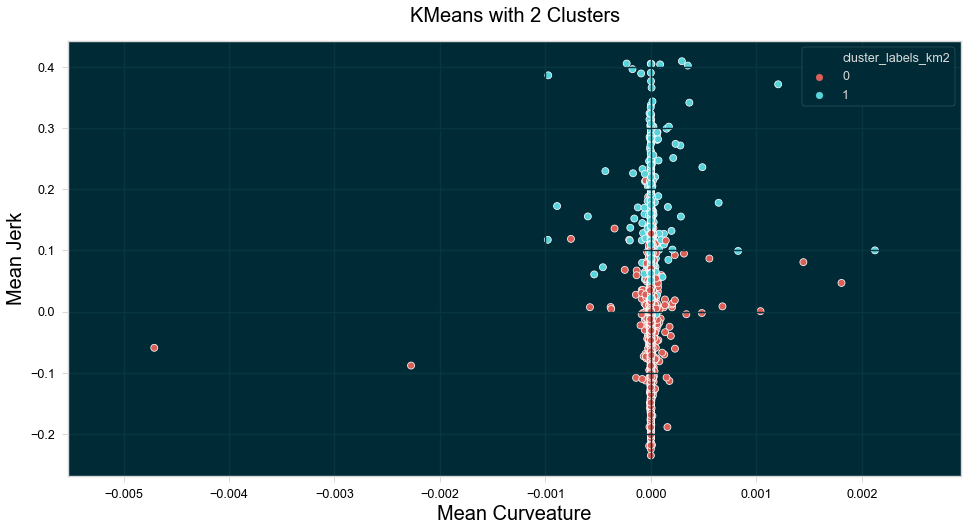

In [144]:
km2 = KMeans(n_clusters=2).fit(norm_train)
actions_train = pd.DataFrame(X_train, columns=cols)
actions_train["cluster_labels_km2"] = km2.labels_

plt.figure(figsize=(16, 8))
sns.scatterplot(actions_train["mean_curv"], actions_train["mean_jerk"],
                hue=actions_train["cluster_labels_km2"],
                palette=sns.color_palette('hls', 2))
plt.title("KMeans with 2 Clusters", color="black", size=20, y=1.03)
plt.xlabel("Mean Curveature", color="black", size=20)
plt.ylabel("Mean Jerk", color="black", size=20)
plt.xticks(color="black")
plt.yticks(color="black")

plt.show()

cluster sizes seem to be massively imbalanced

In [145]:
actions_train["cluster_labels_km2"].value_counts()

0    9792
1    5281
Name: cluster_labels_km2, dtype: int64

In [147]:
y_train.value_counts()

0    7553
1    7520
Name: user16, dtype: int64

In [148]:
pd.crosstab(actions_train["cluster_labels_km2"], y_train, margins=True)

user16                 0     1    All
cluster_labels_km2                   
0                   1982  4882   6864
1                   1032  2638   3670
All                 3014  7520  10534

In [149]:
pred = km2.predict(X_test)

In [150]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.52      0.67      0.59      3214
           1       0.54      0.39      0.46      3247

   micro avg       0.53      0.53      0.53      6461
   macro avg       0.53      0.53      0.52      6461
weighted avg       0.53      0.53      0.52      6461

[[2144 1070]
 [1971 1276]]
